### #3

Kaggle competition: [\[link\]](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

Entry by Robin P.M. Kras

### ⭐ 1. Introduction & Overview


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### 🔹 2. Import Libraries & Set Up


In [190]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Feature Importance & Explainability
import shap

# Settings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries loaded. Ready to go!")

Libraries loaded. Ready to go!


### 🔹 3. Load & Explore Data


In [191]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [192]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [193]:
train.shape

(1460, 81)

In [194]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [195]:
# Quick summary of dataset
train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 🔹 4. Data Visualization & EDA



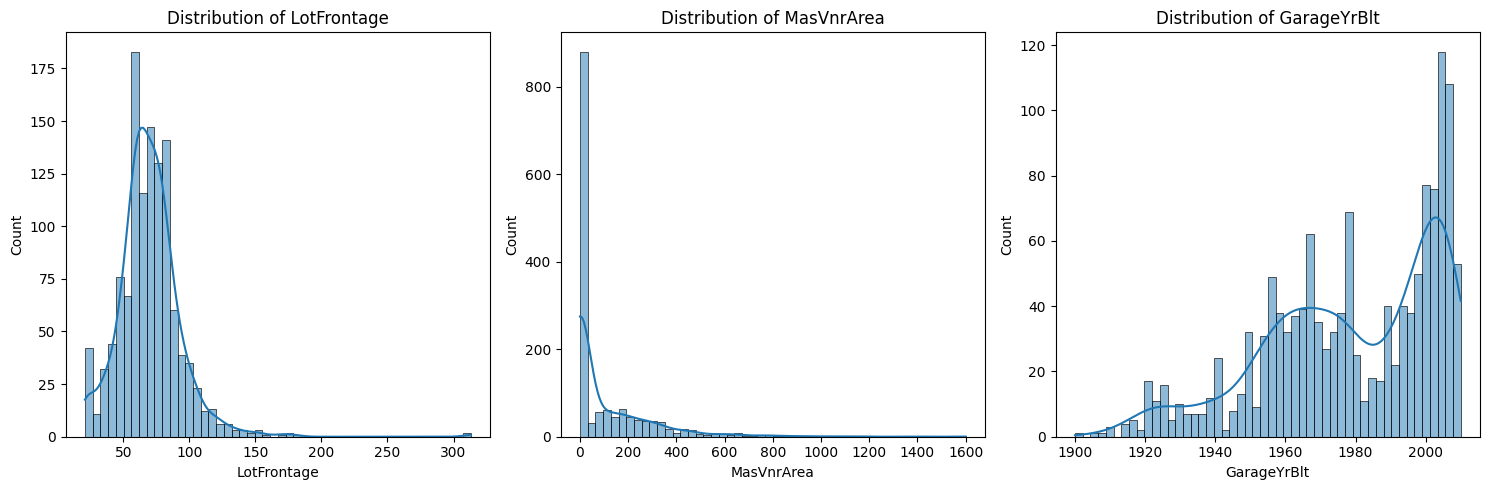

In [196]:
float_cols = [col for col in train.columns if train[col].dtype == "float64"]

cols_per_row = 3
num_plots = len(float_cols)
rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0) 

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows)) 
axes = axes.flatten()  

for idx, col in enumerate(float_cols):
    sns.histplot(train[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

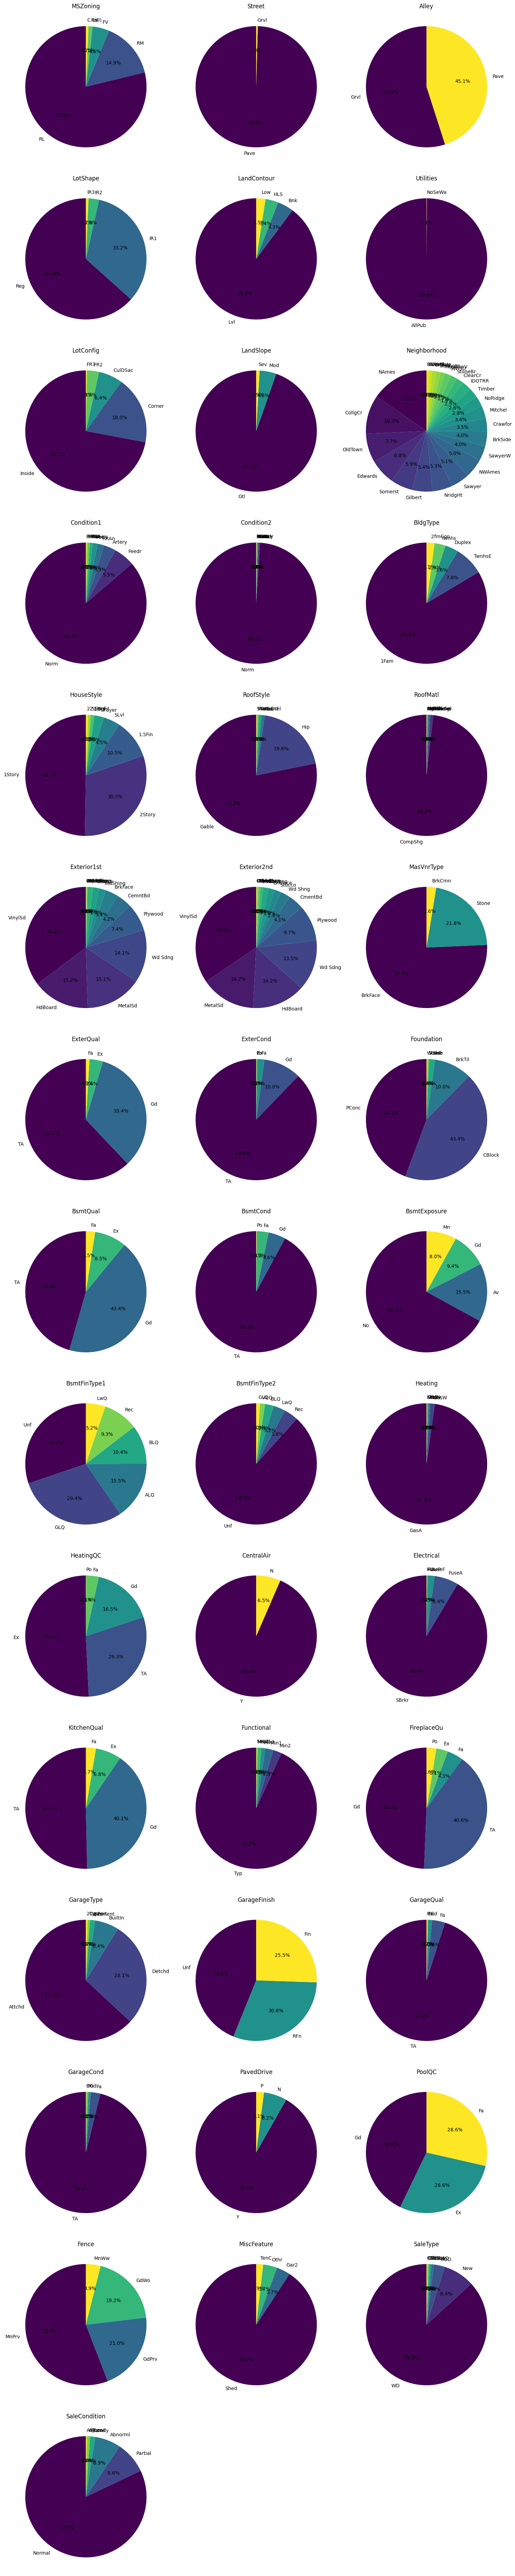

In [197]:
categorical_features = train.select_dtypes(include=['object']).columns

num_features = len(categorical_features)
cols = 3 
rows = (num_features // cols) + (num_features % cols > 0) 

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5)) 
axes = axes.flatten()  

for i, feature in enumerate(categorical_features):
    train[feature].value_counts().plot.pie(
        autopct='%1.1f%%', ax=axes[i], startangle=90, cmap="viridis"
    )
    axes[i].set_title(feature)
    axes[i].set_ylabel("") 

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


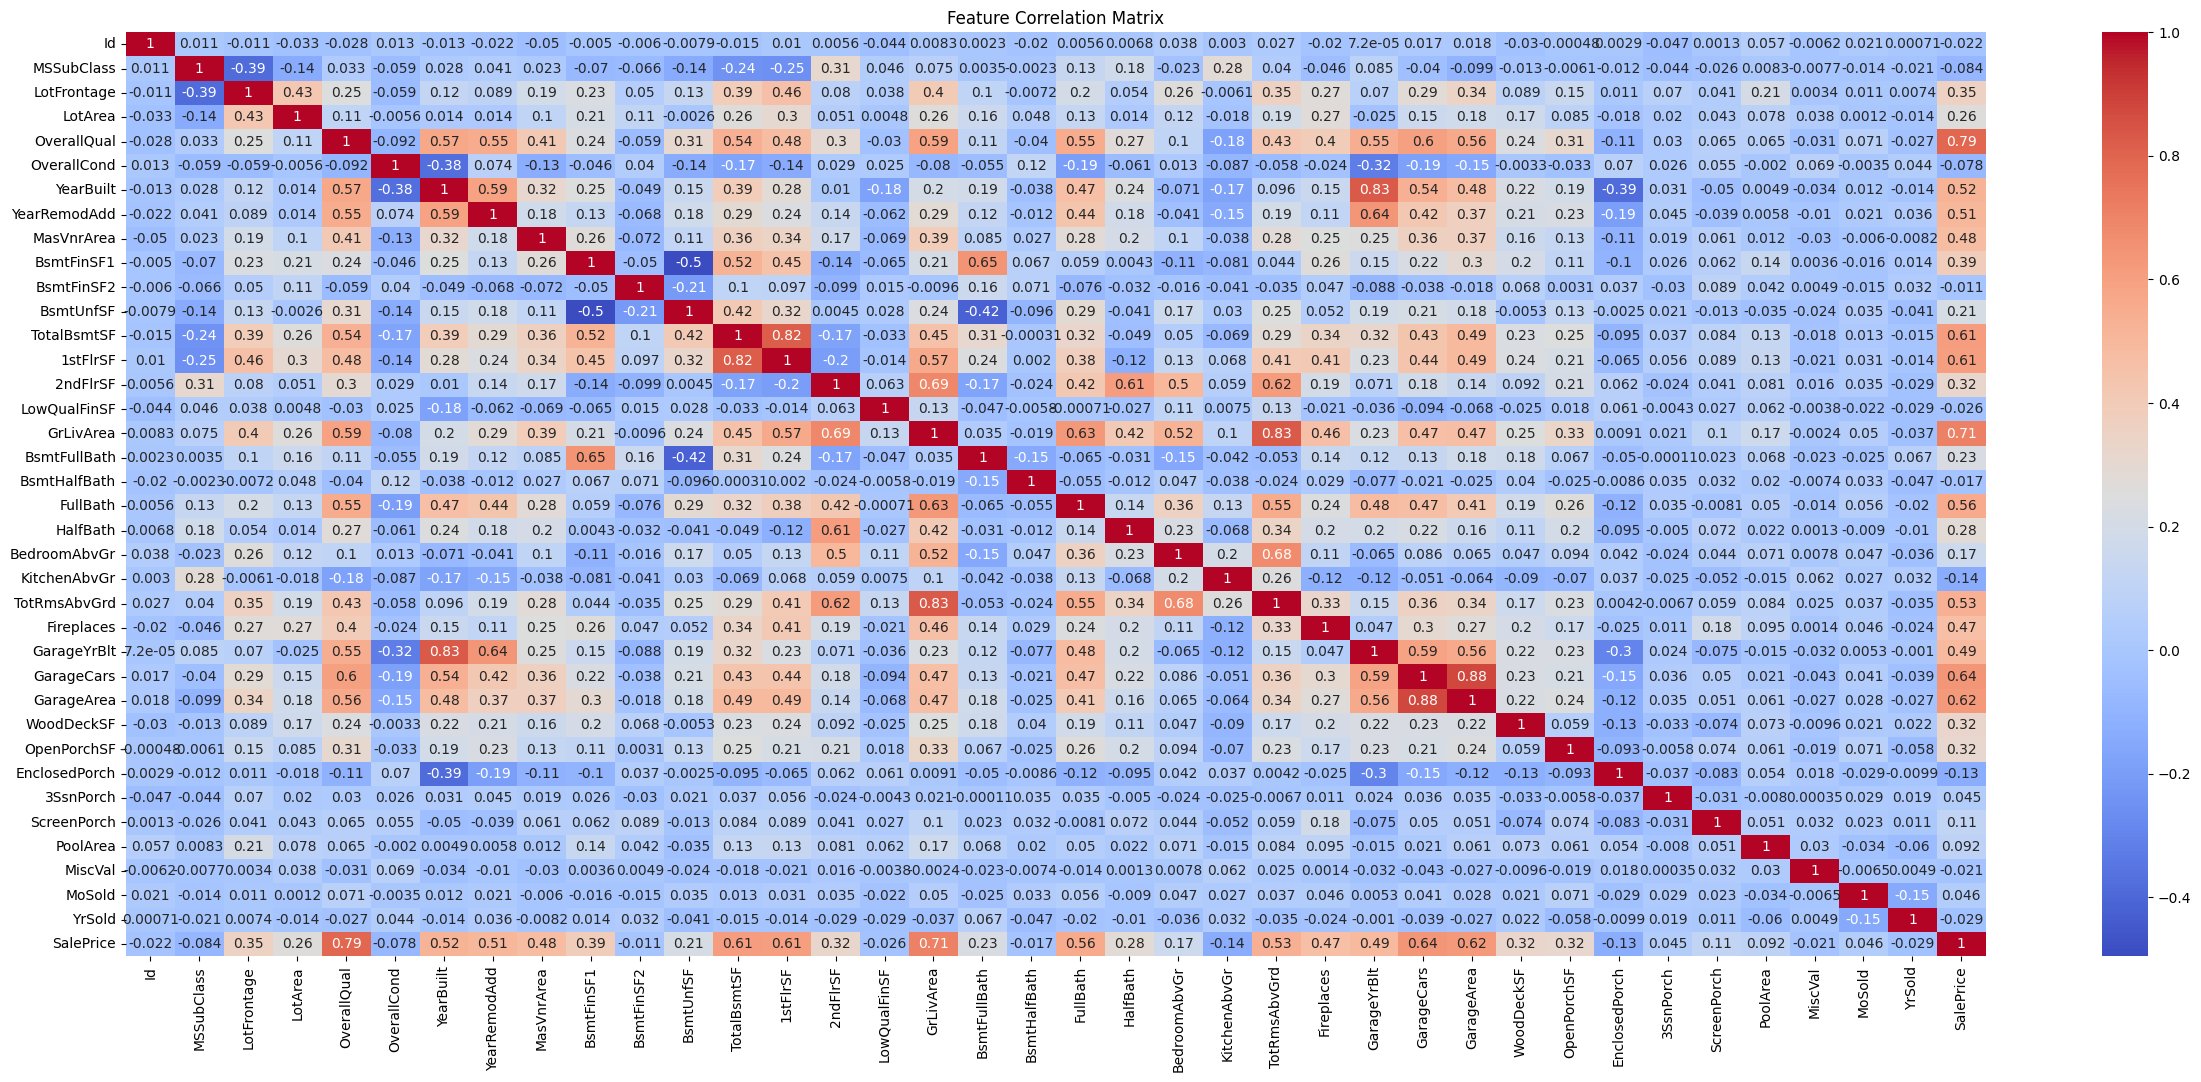

In [198]:
heatmap_train = pd.DataFrame()

for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        heatmap_train[col] = train[col]

plt.figure(figsize=(30,12))
sns.heatmap(heatmap_train.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

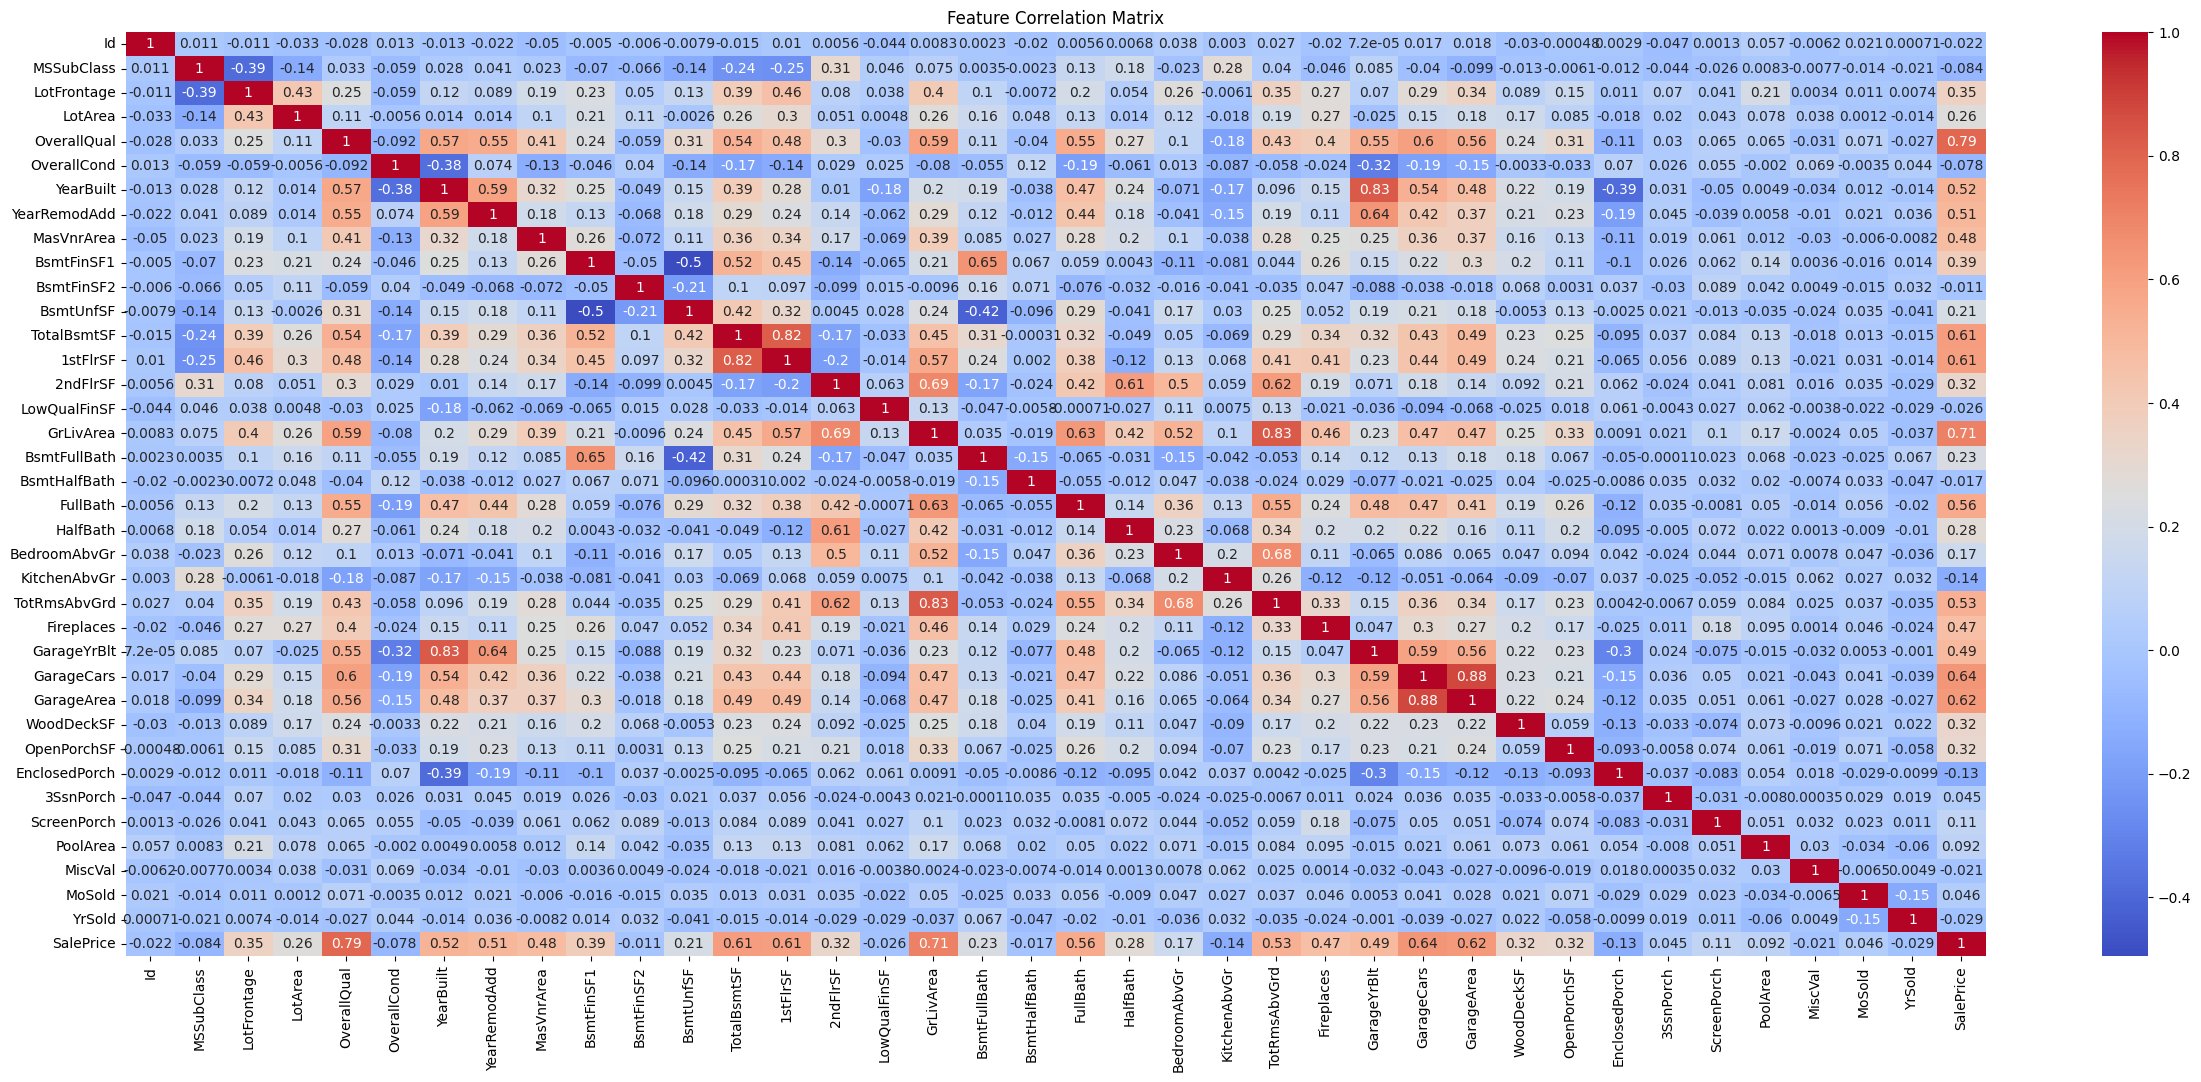

Highly correlated feature pairs (above threshold):
       Feature 1     Feature 2  Correlation
174  OverallQual     SalePrice     0.790982
225    YearBuilt   GarageYrBlt     0.825667
378  TotalBsmtSF      1stFlrSF     0.819530
478    GrLivArea  TotRmsAbvGrd     0.825489
637   GarageCars    GarageArea     0.882475


In [199]:
heatmap_train = train.select_dtypes(include=["float64", "int64"])

corr_matrix = heatmap_train.corr()

threshold = 0.75

high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
    .stack()  
    .reset_index()
)

high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > threshold]  

plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

print("Highly correlated feature pairs (above threshold):")
print(high_corr_pairs)

In [200]:
l1 = high_corr_pairs['Feature 1'].tolist()
l2 = high_corr_pairs['Feature 2'].tolist()
interesting_features = list(set(l1+l2))

interesting_features.remove('SalePrice')

print(interesting_features)

['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea', '1stFlrSF', 'GarageYrBlt', 'GarageCars', 'YearBuilt']


### 🔹 5. Feature Engineering

In [201]:
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [202]:
print(f"Train set, null count: \n{train.isnull().sum()}")
print("\n")
print(f"Test set, null count: \n{test.isnull().sum()}")

Train set, null count: 
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


Test set, null count: 
Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [203]:
outliers = pd.concat([
    train[(train['OverallQual'] == 4) & (train['SalePrice'] > 2e5)],
    train[(train['OverallQual'] == 8) & (train['SalePrice'] > 5e5)],
    train[(train['OverallQual'] == 10) & (train['SalePrice'] > 7e5)],
    train[(train['GrLivArea'] > 4000)],
    train[(train['OverallCond'] == 2) & (train['SalePrice'] > 3e5)],
    train[(train['OverallCond'] == 5) & (train['SalePrice'] > 7e5)],
    train[(train['OverallCond'] == 6) & (train['SalePrice'] > 7e5)]

    ]).sort_index().drop_duplicates()

In [204]:
train = train.drop(outliers.index)

In [205]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [206]:
for col in train.columns:
    if train[col].dtype == "object":
        train[col] = train[col].fillna("None")
    elif train[col].dtype in ["float64", "int64"]:
        train[col] = train[col].fillna(train[col].mean())

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = test[col].fillna("None")
    elif test[col].dtype in ["float64", "int64"]:
        test[col] = test[col].fillna(test[col].mean())    

In [207]:
for col in train.columns:
    if train[col].isnull().sum() > 0:
        print(col)

for col in test.columns:
    if test[col].isnull().sum() > 0:
        print(col)

No more empty items left. Great!

In [208]:
import itertools

def create_combination_features(df, features):
    combinations = itertools.combinations(features, 2)

    for comb in combinations:
        feature_name = "_".join(comb)
        df[feature_name] = df[list(comb)].mean(axis=1)
    
    return df

train = create_combination_features(train, interesting_features)
test = create_combination_features(test, interesting_features)

In [209]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities  ... GarageArea_1stFlrSF GarageArea_GarageYrBlt  \
0         Lvl    AllPub  ...               702.0                 1275.5   
1         Lvl    AllPub  ...               861.0                 1218.0   
2         Lvl    AllPub  ...               764.0                 1304.5   
3         Lvl    AllPub  ...               801.5                 1320.0   
4         Lvl    AllPub  ...               990.5                 1418.0   

  GarageArea_GarageCars GarageArea_YearBuilt 1stFlrSF_GarageYrBlt  \
0                 275.0               1275.5               1429.5   
1                 231.0               1218.0               1619.0   
2                 305.0               1304.5               1460.5   
3                 322.5               1278.5               1479.5   
4                 419.5               1418.0               1572.5   

  1stFlrSF_GarageCars 1stFlrSF_YearBuilt  GarageYrBlt_GarageCars  \
0               429.0             1429.5                  1002.5   
1               632.0             1619.0                   989.0   
2               461.0             1460.5                  1001.5   
3               482.0             1438.0                  1000.5   
4               574.0             1572.5                  1001.5   

   GarageYrBlt_YearBuilt  GarageCars_YearBuilt  
0                 2003.0                1002.5  
1                 1976.0                 989.0  
2                 2001.0                1001.5  
3                 1956.5                 959.0  
4                 2000.0                1001.5  

[5 rows x 118 columns]

In [210]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in train.columns:
    if train[col].dtype == "object":
        train[col] = le.fit_transform(train[col])

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = le.fit_transform(test[col])

### 🔹 6. Model Selection

In [211]:
X = train.drop(columns=["Id", "SalePrice"])
X_test = test.drop(columns=["Id"])

y = train['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],  
    #'learning_rate': [0.01, 0.05, 0.1],  
    #'max_depth': [3, 5, 7, 9],  
    #'subsample': [0.8, 0.9, 1.0], 
    #'colsample_bytree': [0.8, 0.9, 1.0],
    'alpha': [0, 0.01, 0.1, 1],
    'lambda': [0, 0.1, 0.5, 1],
    'gamma': [0, 0.1, 0.2, 1],
    #'early_stopping_rounds': [5, 10, 20, 30]
}

grid_search = GridSearchCV(xg.XGBRegressor(tree_method="gpu_hist", random_state=SEED), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)])

print("Best Parameters:", grid_search.best_params_)

best_params = grid_search.best_params_

[0]	validation_0-rmse:68200.58338	validation_1-rmse:74748.47981
[1]	validation_0-rmse:62443.43453	validation_1-rmse:69041.04398
[2]	validation_0-rmse:57236.27183	validation_1-rmse:63616.72024
[3]	validation_0-rmse:52587.11351	validation_1-rmse:59081.66027
[4]	validation_0-rmse:48370.67513	validation_1-rmse:54924.25403
[5]	validation_0-rmse:44498.31457	validation_1-rmse:51133.11870
[6]	validation_0-rmse:41024.99419	validation_1-rmse:47691.95186
[7]	validation_0-rmse:37906.89800	validation_1-rmse:44860.43264
[8]	validation_0-rmse:35028.33049	validation_1-rmse:42103.81330
[9]	validation_0-rmse:32460.44484	validation_1-rmse:39631.82414
[10]	validation_0-rmse:30153.72735	validation_1-rmse:37490.13745
[11]	validation_0-rmse:28018.28846	validation_1-rmse:35783.47624
[12]	validation_0-rmse:26068.11098	validation_1-rmse:34137.86958
[13]	validation_0-rmse:24279.05849	validation_1-rmse:32595.22585
[14]	validation_0-rmse:22734.49950	validation_1-rmse:31368.83929
[15]	validation_0-rmse:21286.99232	

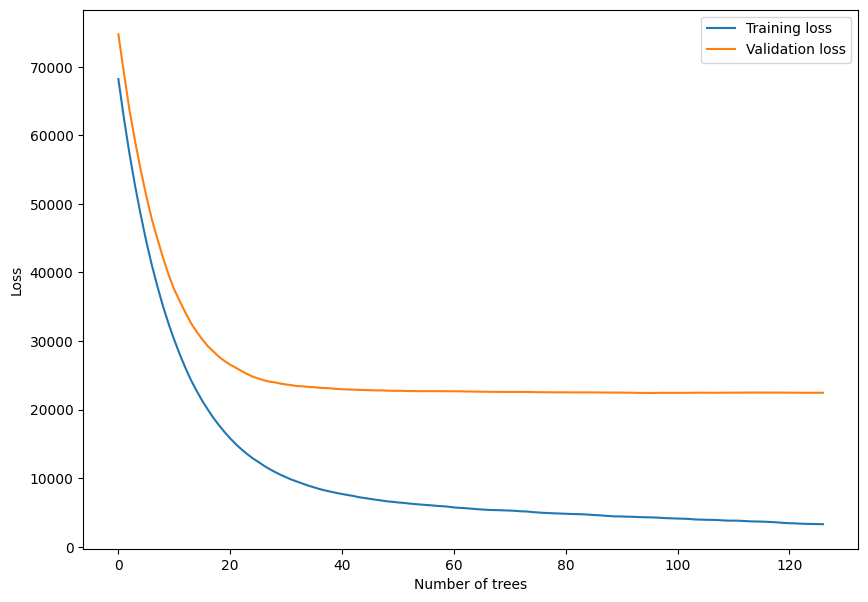

In [213]:
model = xg.XGBRegressor(
    learning_rate=0.1,
    max_depth=6,
    early_stopping_rounds=30,
    n_estimators=200,
    random_state=SEED)

model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)])

results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

predictions = model.predict(X_val)

mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
rms = root_mean_squared_error(y_val, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
print(f"RMSE Score: {rms}")

In [214]:
X_test = test.drop(columns=['Id'])  

predictions = model.predict(X_test)  

output = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})
output.to_csv('submission_xgb.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### 🔹 Experiment

[0]	validation_0-rmse:68692.95549	validation_1-rmse:71468.80278
[1]	validation_0-rmse:62918.01937	validation_1-rmse:65195.72850
[2]	validation_0-rmse:57649.09855	validation_1-rmse:59810.39291
[3]	validation_0-rmse:52956.96228	validation_1-rmse:54739.63582
[4]	validation_0-rmse:48705.10215	validation_1-rmse:50144.94079
[5]	validation_0-rmse:44867.54684	validation_1-rmse:46121.25656
[6]	validation_0-rmse:41466.39687	validation_1-rmse:42394.29842
[7]	validation_0-rmse:38320.51782	validation_1-rmse:39162.25955
[8]	validation_0-rmse:35384.73829	validation_1-rmse:36240.14309
[9]	validation_0-rmse:32804.86725	validation_1-rmse:33493.54485
[10]	validation_0-rmse:30405.63712	validation_1-rmse:31062.94576
[11]	validation_0-rmse:28255.76638	validation_1-rmse:28898.78443
[12]	validation_0-rmse:26337.84239	validation_1-rmse:26989.61587
[13]	validation_0-rmse:24599.30967	validation_1-rmse:25094.60023
[14]	validation_0-rmse:23018.69847	validation_1-rmse:23472.90585
[15]	validation_0-rmse:21610.96075	

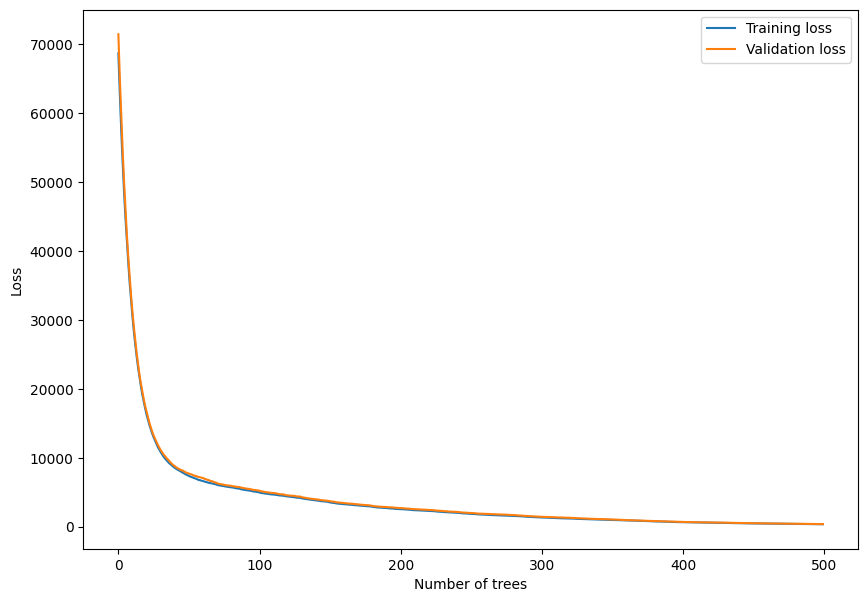

In [215]:
y = train["SalePrice"]

X = pd.get_dummies(train.drop(columns=["SalePrice"]))
X_test = pd.get_dummies(test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=SEED)

model = xg.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6,
    early_stopping_rounds=20,
    alpha=1,
    lambda_=1,
    gamma=0.1,
    random_state=SEED)
    
model.fit(X, y, 
            eval_set=[(X_train, y_train), (X_val, y_val)])

results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

rms = min(results["validation_1"].values(), key=min)
rms = min(rms)

predictions = model.predict(X_test)
predictions_val = model.predict(X_val)

print(f"RMSE Score: {rms}")

output = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})
output.to_csv('submission_experiment.csv', index=False)
print("Your submission was successfully saved!")

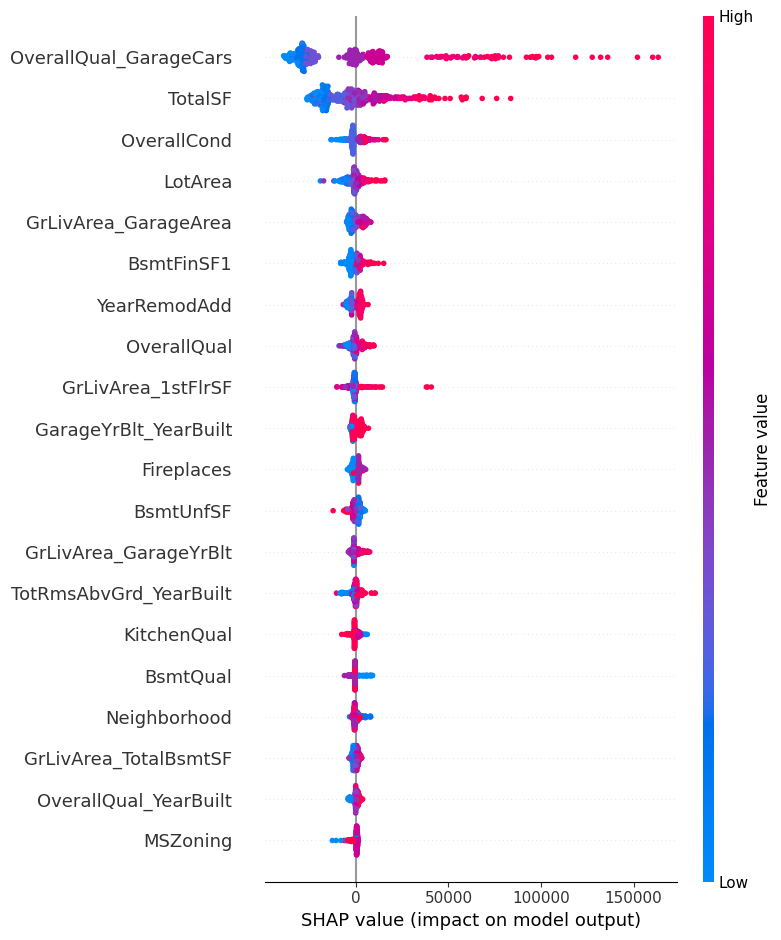

In [216]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)
shap.force_plot(explainer.expected_value, shap_values[0], X_val.iloc[0])